In [2]:
import pandas as pd
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

3.4.1


# Reaction Times In A Sleep Deprivation Study
The dataset contains the average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject. Data from: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv

### Data loading

In [2]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head(15)

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308
6,414.6901,5,308
7,382.2038,6,308
8,290.1486,7,308
9,430.5853,8,308
10,466.3535,9,308


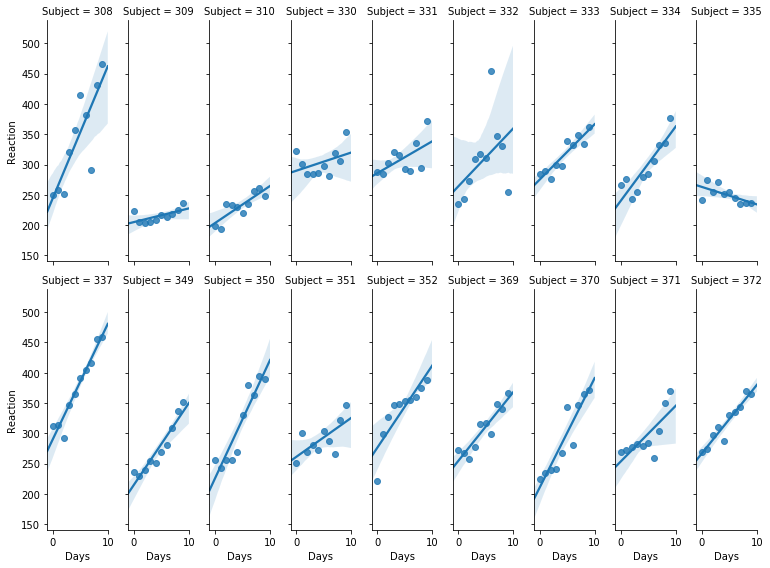

In [3]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.3, size=4)


## Model 1: Random effect on only the intercepts

Design matrix for the fixed effect

In [4]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:10, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

Design matrix for the random effect (intercept only). This means that each subject will deviate from the average intercecpt by some amount, but the slope will be the same across participants

In [5]:
Z = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [6]:
Y = np.asarray(sleep['Reaction'])
Y.mean()

298.50789166666664

In [7]:
with pm.Model() as model:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # Intercept is constrained to be positive because reaction time are positive only
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)

    # Non Centered version
    # The idea behind the non-centered version is to make sampling easier by sampling on probability distributions with the similar dimension. 
    # For example if the sampler is tune on a Normal (0, 1), it will have worse performance in sampling tiny values because the leap frog jump will be to long.
    # Hence, we sample the gamma_raw value and a scaler independently. Normal(0, 30) is the same as N(0, 1) * 30
    scaler_Z = pm.HalfNormal('scaler_Z', sd=100) # The scaler is quite wide since the intercept value can vary quite much around the average value of 300 ms.

    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * scaler_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfNormal('sigma', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=3000, chains=4, njobs=4, tune=1500, nuts_kwargs={'target_accept':0.95})

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '3376' (I am process '2236')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, gamma_Z_raw, scaler_Z_log__, beta_X_slope, beta_X_intercept_log__]
The number of effective samples is smaller than 25% for some parameters.


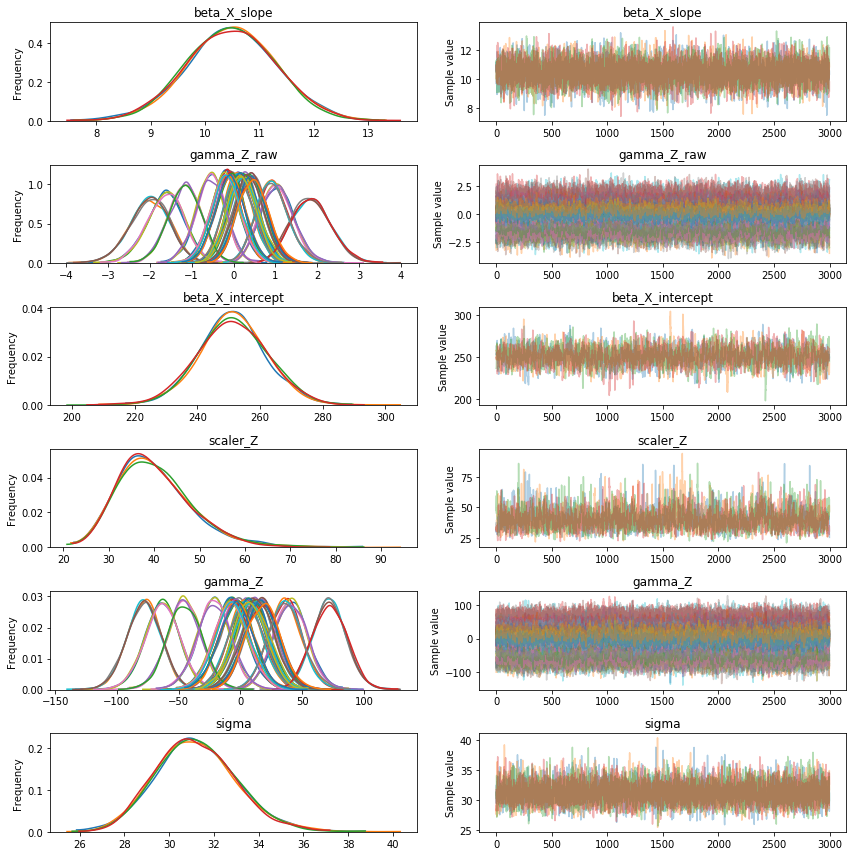

In [8]:
_ = pm.traceplot(trace)

In [9]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X_slope,10.489232,0.809703,0.009080,8.978840,12.159585,8634.252095,1.000076
gamma_Z_raw__0,1.044966,0.394726,0.008025,0.310044,1.844181,2454.683291,1.000470
gamma_Z_raw__1,-2.002716,0.474126,0.009339,-2.907554,-1.052368,2528.285012,0.999903
gamma_Z_raw__2,-1.624926,0.438709,0.008365,-2.538372,-0.820178,2560.770147,0.999908
gamma_Z_raw__3,0.113959,0.342945,0.006139,-0.527309,0.804303,2907.050514,1.000254
gamma_Z_raw__4,0.262574,0.348597,0.006064,-0.433304,0.941951,2976.639855,1.000026
gamma_Z_raw__5,0.215020,0.344617,0.006128,-0.445070,0.902405,2867.059752,1.000038
gamma_Z_raw__6,0.422633,0.349464,0.006376,-0.292158,1.085999,2686.426258,0.999976
gamma_Z_raw__7,-0.075085,0.342269,0.005964,-0.737657,0.601934,2968.715564,1.000147
gamma_Z_raw__8,-1.167653,0.389288,0.007304,-1.935810,-0.414769,2681.416606,0.999927


In [10]:
#pm.plot_posterior(trace);

## Posterior predictive check

In [11]:
trace_df = pm.trace_to_dataframe(trace)

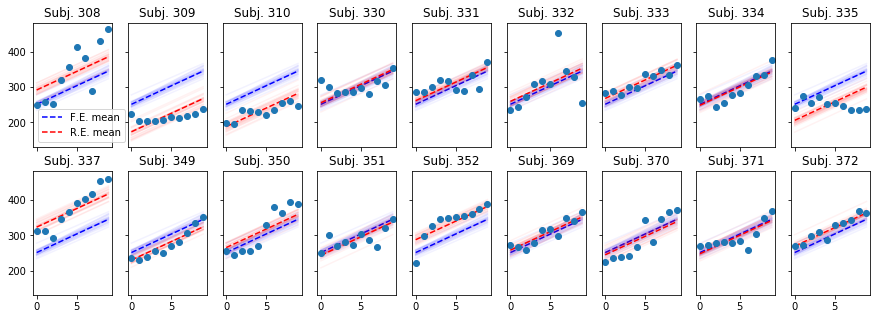

In [12]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0 in trace_df['gamma_Z__{}'.format(i)][::500]:
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * trace_df['beta_X_slope'].mean(), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z__{}'.format(i)].mean() + 
               days * trace_df['beta_X_slope'].mean(), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

## Random effect on the intercepts and slopes
Note: It may be beneficial to center and standardize the data

Design matrix for the fixed effect

In [13]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:15, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.],
       [1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.]])

Design matrix for the random effects. Intercept and slope are modelled separately to have more control on the prior

In [14]:
# Random effect on the intercepts and slopes
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)

print('Z_intercept has shape ({}, {})'.format(*Z_intercept.shape))
print('Z_slope has shape ({}, {})'.format(*Z_slope.shape))
print('Z has shape ({}, {})'.format(*Z.shape))

Z_intercept has shape (180, 18)
Z_slope has shape (180, 18)
Z has shape (180, 36)


In [15]:
Z_intercept

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [16]:
Z_slope

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [17]:
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [18]:
Y = np.asarray(sleep['Reaction'])

In [19]:
with pm.Model() as model:
   
    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
    
    ## Random effect
    # Non Centered version
    scaler_intercept = pm.HalfNormal('scaler_intercept', sd=100)
    gamma_Z_intercept_raw = pm.Normal('gamma_Z_intercept_raw', mu=0, sd=1, shape=Z_intercept.shape[1])
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z_intercept_raw * scaler_intercept)

    scaler_slope = pm.HalfNormal('scaler_slope', sd=100)
    gamma_Z_slope_raw = pm.Normal('gamma_Z_slope_raw', mu=0, sd=1, shape=Z_slope.shape[1])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z_slope_raw * scaler_slope)
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 
    
    ## likelihood
    mu_estimate = pm.Deterministic('mu_estimate', estimate_X + estimate_Z)
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace = pm.sample(draws=3000, chains=4, njobs=4, tune=1500, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_unexplained_log__, gamma_Z_slope_raw, scaler_slope_log__, gamma_Z_intercept_raw, scaler_intercept_log__, beta_X_slope, beta_X_intercept_log__]


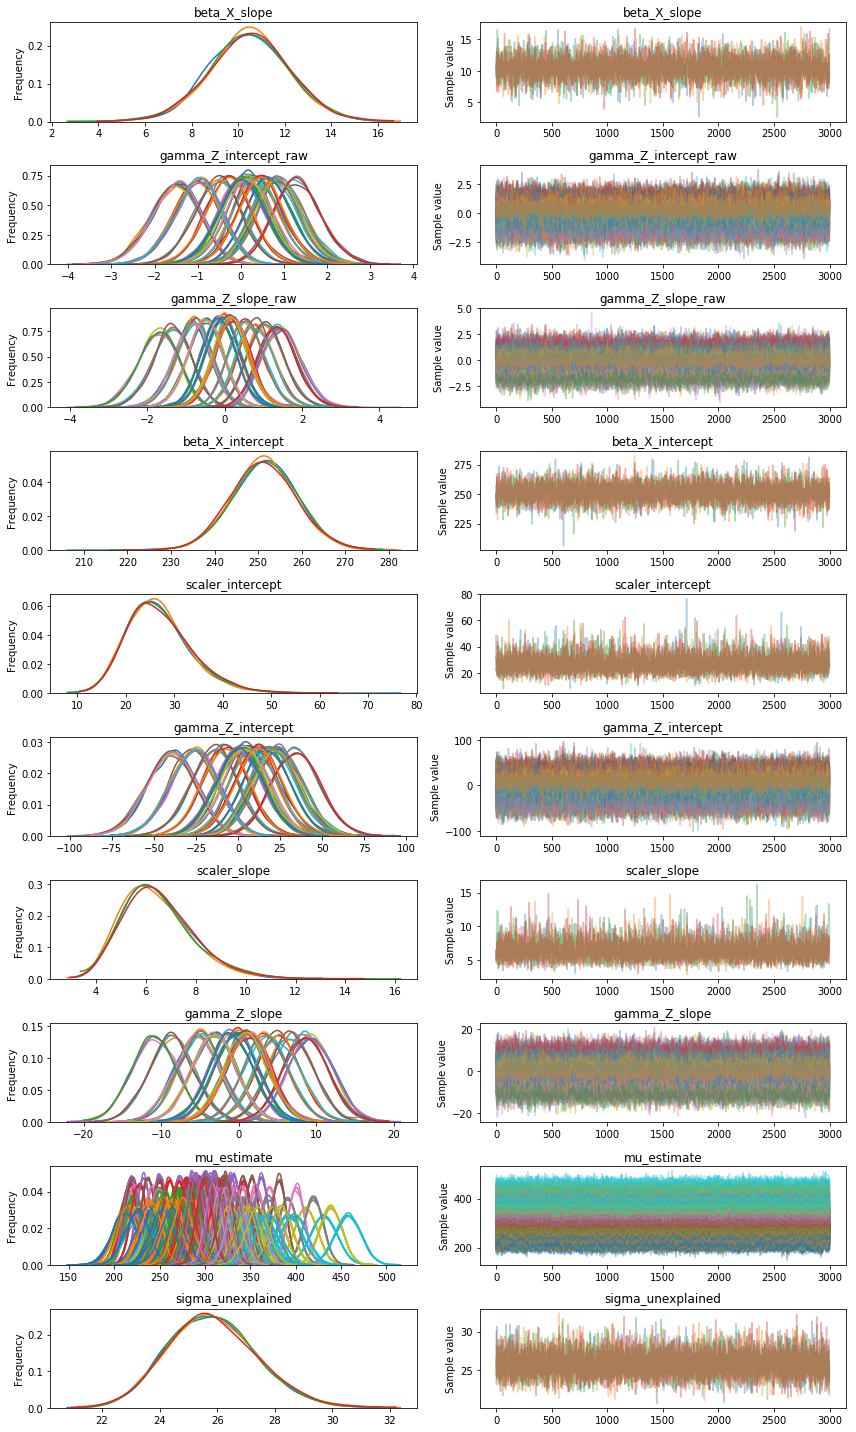

In [20]:
_ = pm.traceplot(trace)

In [21]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X_slope,10.475709,1.693732,0.020970,7.208722,13.862441,4815.035964,0.999980
gamma_Z_intercept_raw__0,0.050685,0.548005,0.004812,-1.015939,1.152610,12103.993355,1.000252
gamma_Z_intercept_raw__1,-1.538353,0.571711,0.005651,-2.673353,-0.469847,10934.201894,0.999953
gamma_Z_intercept_raw__2,-1.498248,0.566221,0.005579,-2.610913,-0.388011,10231.274336,1.000036
gamma_Z_intercept_raw__3,0.945489,0.546317,0.004156,-0.093382,2.042674,12792.251836,0.999934
gamma_Z_intercept_raw__4,0.871143,0.542092,0.004666,-0.193148,1.919400,13194.691350,0.999981
gamma_Z_intercept_raw__5,0.354129,0.521423,0.004787,-0.649848,1.395407,12705.561650,0.999907
gamma_Z_intercept_raw__6,0.654309,0.528355,0.004976,-0.387515,1.680157,11833.764776,0.999842
gamma_Z_intercept_raw__7,-0.282176,0.525631,0.004590,-1.317281,0.749924,13109.250822,1.000093
gamma_Z_intercept_raw__8,0.023117,0.543214,0.004959,-1.059099,1.106647,12023.444538,1.000205


In [22]:
#pm.plot_posterior(trace);

In [23]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.head().T

,0,1,2,3,4
beta_X_slope,9.003865,11.363994,10.205913,12.282492,10.355473
gamma_Z_intercept_raw__0,0.363356,0.547155,0.595927,0.093968,0.025879
gamma_Z_intercept_raw__1,-1.752797,-1.029491,-0.976113,-0.765319,-2.401955
gamma_Z_intercept_raw__2,-1.824638,-0.438871,-0.671520,-0.497238,-2.823131
gamma_Z_intercept_raw__3,1.279556,0.675984,0.768967,0.958437,1.063338
gamma_Z_intercept_raw__4,0.637901,1.035566,1.210104,1.150714,0.340220
gamma_Z_intercept_raw__5,1.078264,0.470900,0.428963,0.822233,-0.644406
gamma_Z_intercept_raw__6,1.065721,0.665706,0.850329,0.667953,0.426115
gamma_Z_intercept_raw__7,-0.872984,0.256505,0.501986,-0.125318,-0.445873
gamma_Z_intercept_raw__8,0.372055,0.242120,0.081777,0.681120,-1.106290


In [24]:
yvars = [col for col in trace_df.columns if 'gamma_Z_slope' in col and 'raw' not in col]
xvars = [col for col in trace_df.columns if 'gamma_Z_intercept' in col and 'raw' not in col]

xvars

['gamma_Z_intercept__0',
 'gamma_Z_intercept__1',
 'gamma_Z_intercept__2',
 'gamma_Z_intercept__3',
 'gamma_Z_intercept__4',
 'gamma_Z_intercept__5',
 'gamma_Z_intercept__6',
 'gamma_Z_intercept__7',
 'gamma_Z_intercept__8',
 'gamma_Z_intercept__9',
 'gamma_Z_intercept__10',
 'gamma_Z_intercept__11',
 'gamma_Z_intercept__12',
 'gamma_Z_intercept__13',
 'gamma_Z_intercept__14',
 'gamma_Z_intercept__15',
 'gamma_Z_intercept__16',
 'gamma_Z_intercept__17']

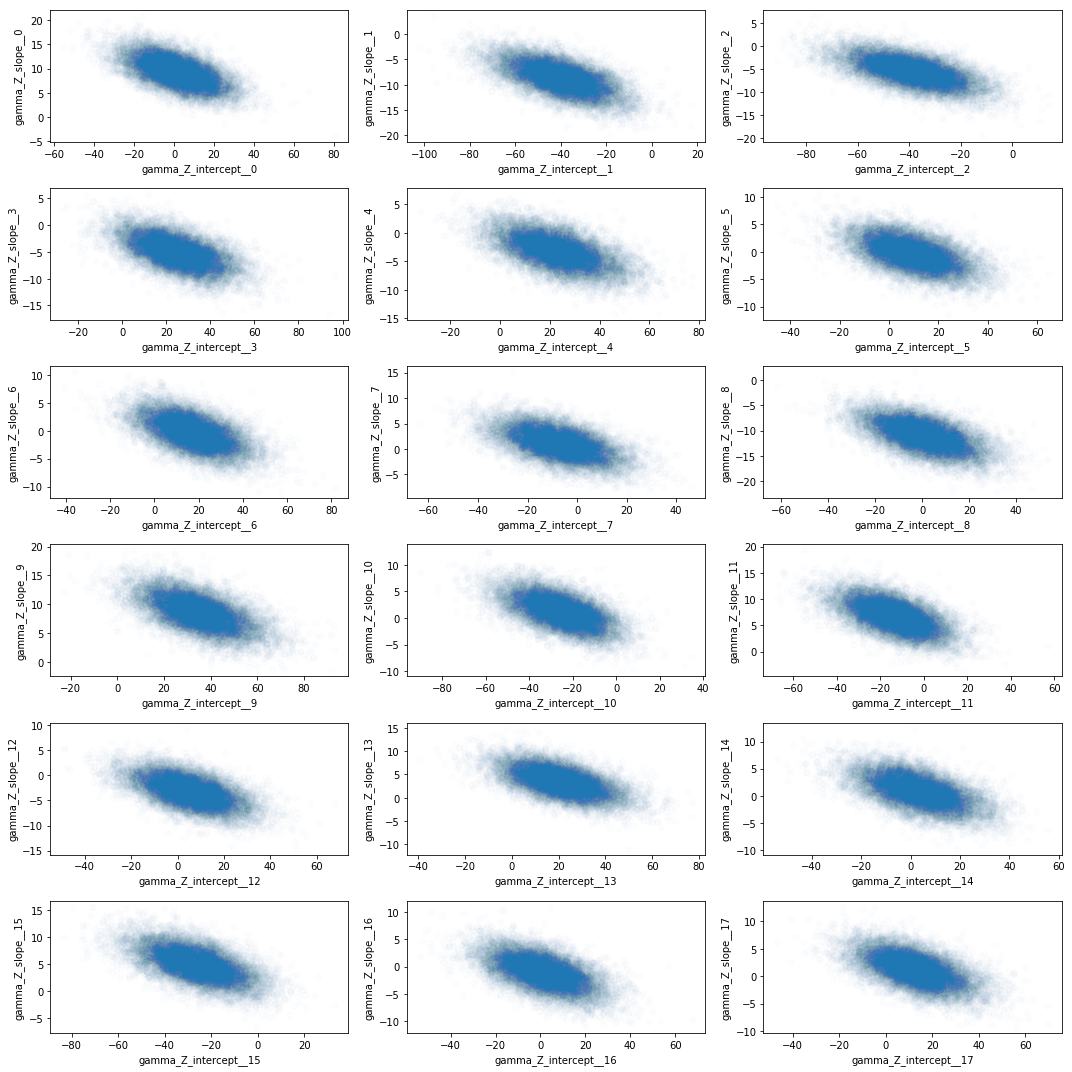

In [25]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
for i, axi in enumerate(ax.ravel()):
    axi.plot(trace_df[xvars[i]], trace_df[yvars[i]], 'o', alpha=0.01)
    axi.set_xlabel(xvars[i])
    axi.set_ylabel(yvars[i])
    
plt.tight_layout()

## Posterior predictive check

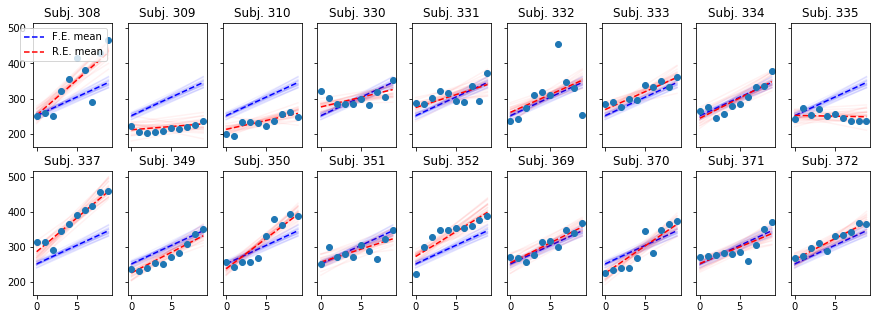

In [26]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                      trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * (trace_df['beta_X_slope'].mean() + b1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

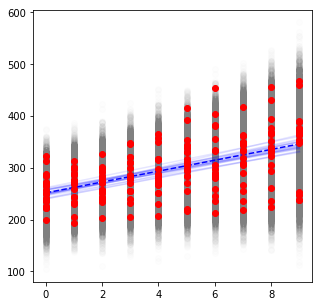

In [27]:
# Posterior distribution
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

n_draws = 25
for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    for mu, sigma in zip(trace_df['mu_estimate__{}'.format(idx)][1000::500], trace_df['sigma_unexplained'][1000::500]):
        ax.plot(np.repeat(day, n_draws), np.random.normal(loc=mu, scale=sigma, size=n_draws),
                'o',color=(0.5, 0.5, 0.5), alpha=0.01)
    
for b0, b1 in zip(trace_df['beta_X_intercept'][1000::500], trace_df['beta_X_slope'][1000::500]):
    ax.plot(np.unique(sleep.Days), b0 + np.unique(sleep.Days)*b1, '-b', alpha=0.1)

ax.plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b')

for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    ax.plot(day, reaction, 'ro', alpha=1)


In [28]:
ppc = pm.sample_ppc(trace, samples=250, model=model)

100%|████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 1067.45it/s]


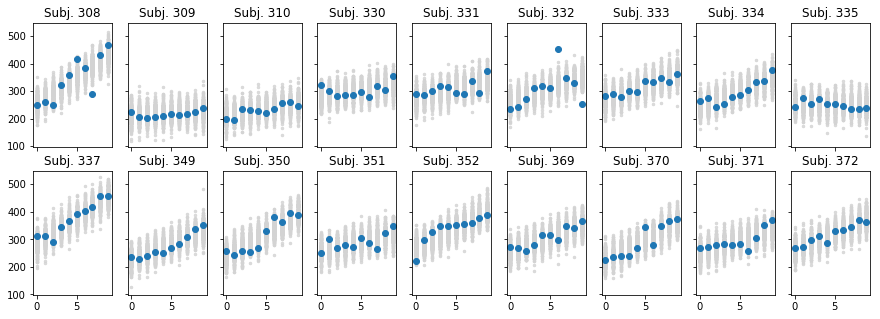

In [29]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))


## Model 3: Correlation among random effects
see: https://docs.pymc.io/notebooks/LKJ.html

In [31]:
n_random_effects = X.shape[1] #nu = 2
n_subjects = Z_intercept.shape[1] # J = 18

with pm.Model() as model:
   #    tt.printing.Print('cholesky_factor_corr')(cholesky_factor_corr.shape) 
    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
        
    ## Random effect
    # Prior on the standard deviation of the random effects
    sigma_Z = pm.HalfCauchy.dist(beta=3, shape=n_random_effects)
    
    # Build the covariance matrix
    chol_packed = pm.LKJCholeskyCov('chol_packed', n=n_random_effects, eta=2, sd_dist=sigma_Z)
    chol = pm.expand_packed_triangular(n_random_effects, chol_packed)
    
    covariance_matrix = pm.Deterministic('covariance_matrix', tt.dot(chol, chol.T))
    standard_deviations = pm.Deterministic('standard_deviations', tt.sqrt(tt.diag(covariance_matrix)))
    
    # independent component for each subject and each random effect
    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=(n_random_effects, n_subjects))
    
    # Compute the correlated random variables via the covariance matrix
    gamma_Z = tt.dot(chol, gamma_Z_raw)
    tt.printing.Print('gamma_Z')(gamma_Z.shape)
    
    # Separate coefficients for intercept and slope
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z[0, :])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z[1, :])
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 

    ## likelihood
    mu_estimate = pm.Deterministic('mu_estimate', estimate_X + estimate_Z)
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace = pm.sample(draws=3000, chains=4, njobs=4, tune=1500, nuts_kwargs={'target_accept':0.95})

gamma_Z __str__ = [ 2 18]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_unexplained_log__, gamma_Z_raw, chol_packed_cholesky_cov_packed__, beta_X_slope, beta_X_intercept_log__]


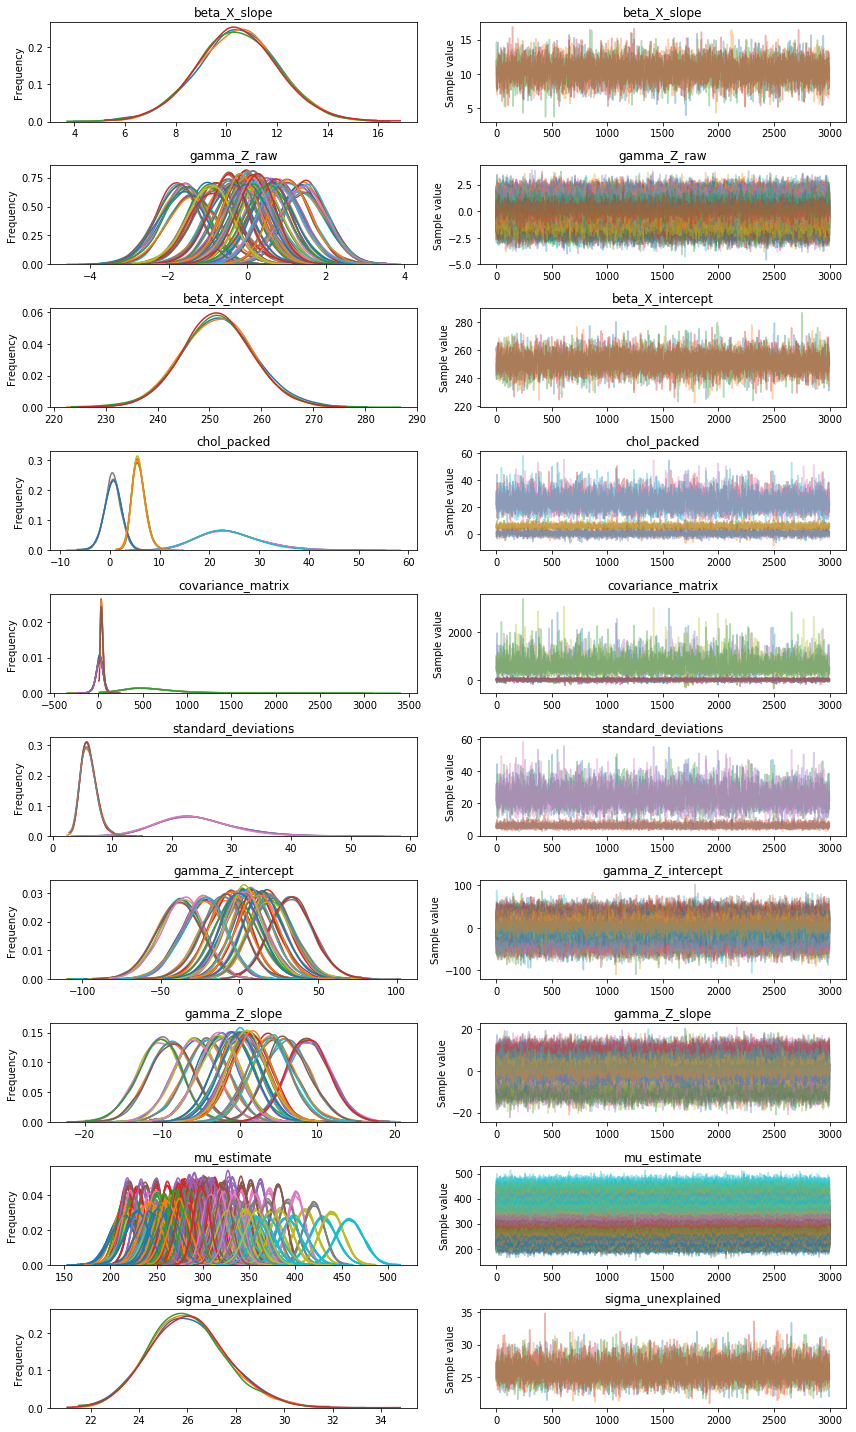

In [32]:
_ = pm.traceplot(trace)

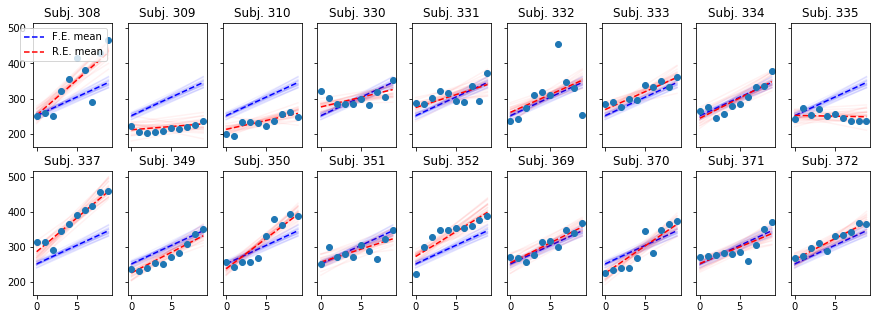

In [33]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                      trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * (trace_df['beta_X_slope'].mean() + b1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

In [34]:
ppc = pm.sample_ppc(trace, samples=250, model=model)

100%|████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 1125.32it/s]


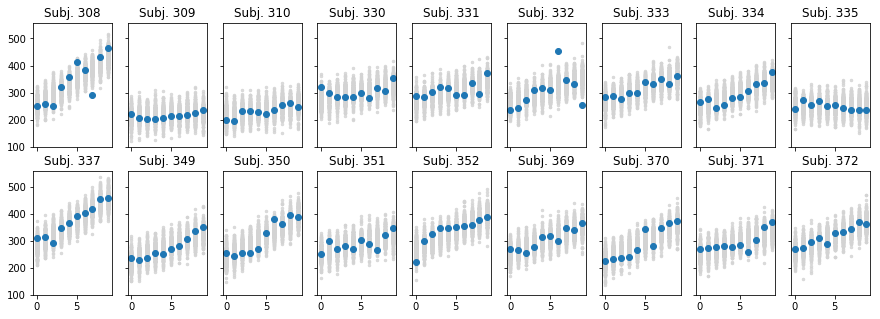

In [35]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))


In [36]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.head().T

,0,1,2,3,4
beta_X_slope,11.066134,11.980891,10.272006,10.299800,8.415676
gamma_Z_raw__0_0,-0.136802,0.392576,0.917624,0.088174,0.799938
gamma_Z_raw__0_1,-1.375461,-1.429583,-1.958958,-0.912127,-1.911038
gamma_Z_raw__0_2,-2.386987,-2.666086,-0.716131,-1.896044,-0.997682
gamma_Z_raw__0_3,0.196609,-0.889897,1.550708,0.511307,1.001767
gamma_Z_raw__0_4,0.893820,0.326817,1.061832,0.943250,0.988535
gamma_Z_raw__0_5,-0.847241,-0.105508,1.043791,-0.121442,1.175803
gamma_Z_raw__0_6,0.236119,0.205000,1.202278,1.082017,0.794623
gamma_Z_raw__0_7,-0.900544,-1.055508,0.182965,0.052243,-0.141199
gamma_Z_raw__0_8,-0.240681,-0.838488,0.342256,-0.124227,0.176053


## Khatri Rao product to construct Z

In [37]:
J = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
J = np.asarray(J)
J.shape

(180, 18)

In [38]:
X.shape

(180, 2)

In [39]:
Z_kr = np.zeros((J.shape[0], X.shape[1]*J.shape[1]))
Z_kr.shape

(180, 36)

In [40]:
np.kron(J[0, :], X[0, :]).shape

(36,)

In [41]:
for ji in np.arange(0, J.shape[1]):
    for xi in np.arange(0, X.shape[1]):
        Z_kr[ji, :] = np.kron(J[ji, :], X[xi, :])

In [42]:
Z_kr.shape

(180, 36)

In [43]:
Z.shape

(180, 36)

In [44]:
Z_kr[:10, :10]

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [45]:
Z[-10:-1, -10:-1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])